# Accidental Opiate Overdose Deaths
### Looking at Features of Prescribers

This [Kaggle dataset](https://www.kaggle.com/apryor6/us-opiate-prescriptions/home) contains information on prescription opiate overdoses by prescriber. From the Kaggle description:
>This dataset contains summaries of prescription records for 250 common opioid and non-opioid drugs written by 25,000 unique licensed medical professionals in 2014 in the United States for citizens covered under Class D Medicare as well as some metadata about the doctors themselves. 

Due to the large and often binarized nature of this dataset, I decided to explore it with some supervised and unsupervised modeling techniques. I first looked at this dataset using a Random Forest Classifier to predict the boolean value for whether or not the prescriber prescribed opiate drugs more than 10 times in the year. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier 
from sklearn.cluster import KMeans, k_means, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

%matplotlib inline

In [2]:
opiods = pd.read_csv('./opioids.csv')
overdoses = pd.read_csv('./overdoses.csv')
prescribers = pd.read_csv('./prescriber-info.csv')

In [3]:
prescribers.shape

(25000, 256)

In [4]:
prescribers.fillna('Unspecified', inplace=True) # Specialty column missing data

In [5]:
prescribers.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [6]:
specialty_dummies = pd.get_dummies(prescribers['Specialty'])
state_dummies = pd.get_dummies(prescribers['State'])

In [7]:
prescribers['Opioid.Prescriber'].value_counts()

1    14688
0    10312
Name: Opioid.Prescriber, dtype: int64

In [8]:
prescribers['Gender'] = prescribers['Gender'].map({'M': 1, 'F': 0})

In [9]:
X = pd.concat([prescribers.drop(['State','Specialty','Credentials','NPI','Opioid.Prescriber'], axis=1),
           specialty_dummies, state_dummies], axis=1)
y = prescribers['Opioid.Prescriber']

In [10]:
X.dtypes.value_counts()

int64    251
uint8    166
dtype: int64

In [11]:
y.value_counts()

1    14688
0    10312
Name: Opioid.Prescriber, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)

In [13]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('rf', RandomForestClassifier(random_state=24))])

In [14]:
params = {
    'rf__n_estimators': [10, 30, 50],
    'rf__max_features': ['auto','log2', 0.25, 0.5]
}

gs = GridSearchCV(pipe, params, scoring='accuracy')

In [15]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_i...timators=10, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': [10, 30, 50], 'rf__max_features': ['auto', 'log2', 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [16]:
gs.score(X_train, y_train)

0.99856

In [17]:
gs.score(X_test, y_test)

0.92544000000000004

In [18]:
gs.best_params_

{'rf__max_features': 0.25, 'rf__n_estimators': 50}

In [19]:
feat_imps = list(gs.best_estimator_.steps[1][1].feature_importances_)

In [20]:
features = pd.DataFrame(list(zip(X.columns, feat_imps)), columns=['Feature','Importance'])

In [21]:
top_feats = features.sort_values('Importance', ascending=False).head(10)
top_feats.set_index('Feature', inplace=True)

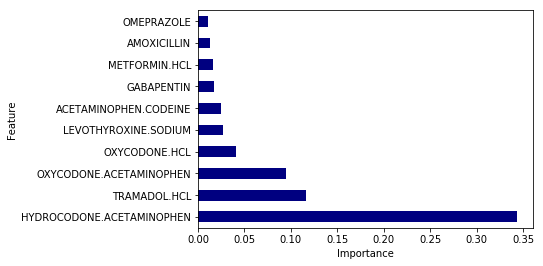

In [22]:
top_feats['Importance'].plot(kind='barh', color='navy')
plt.ylabel('Feature')
plt.xlabel('Importance');
# This isn't surprising at all
# But what are amoxicillin and gabapentin doing there?

In [23]:
# look at it without hydrocodone acetaminophen?
# unsupervised learning, clustering to group providers into categories, use as feature

**K Means Labels**

In [24]:
def km_value_counts(max_clusters, data):
    for n in range(2, max_clusters):
        print (n, "Clusters \n")
        km=KMeans(n_clusters=n)
        model=km.fit(data)
        print(pd.Series(model.labels_).value_counts(), "\n")

In [25]:
km_value_counts(6, X) # unbalanced

2 Clusters 

0    23008
1     1992
dtype: int64 

3 Clusters 

1    21840
0     2656
2      504
dtype: int64 

4 Clusters 

1    20954
3     2839
2     1049
0      158
dtype: int64 

5 Clusters 

1    20735
0     2806
2     1099
4      183
3      177
dtype: int64 



**DB Scan Labels**

In [26]:
db=DBSCAN()

In [27]:
dbmodel = db.fit(X)

In [28]:
pd.Series(dbmodel.labels_).value_counts() # also wicked unbalanced

-1     24869
 3        11
 0        10
 5         8
 6         8
 11        7
 10        7
 4         7
 9         6
 7         6
 12        6
 13        6
 19        6
 14        6
 17        6
 15        6
 8         5
 18        5
 2         5
 1         5
 16        5
dtype: int64

It doesn't seem like unsupervised learning will help create a valuable feature for this model, although DBSCAN is helpful for identifying outliers. 

In [29]:
X['DB_Labels'] = dbmodel.labels_

In [30]:
def explore_outliers(labels):
    for n in labels:
        df=X[X['DB_Labels']==n].copy()
        sums=pd.DataFrame(df.drop(["DB_Labels", "Gender"], axis=1).sum(axis=0), columns=['Sums'])
        print("Label",n)
        print(sums.query("Sums > 0"), "\n")

In [31]:
explore_outliers([lab for lab in dbmodel.labels_ if lab != -1])

Label 0
             Sums
AMOXICILLIN   120
Dentist        10
CA             10 

Label 1
             Sums
AMOXICILLIN    70
Dentist         5
IL              5 

Label 2
             Sums
AMOXICILLIN    85
Dentist         5
PA              5 

Label 3
             Sums
AMOXICILLIN   143
Dentist        11
CA             11 

Label 4
             Sums
AMOXICILLIN    98
Dentist         7
NY              7 

Label 4
             Sums
AMOXICILLIN    98
Dentist         7
NY              7 

Label 5
             Sums
AMOXICILLIN   128
Dentist         8
CA              8 

Label 6
             Sums
AMOXICILLIN    88
Dentist         8
CA              8 

Label 3
             Sums
AMOXICILLIN   143
Dentist        11
CA             11 

Label 4
             Sums
AMOXICILLIN    98
Dentist         7
NY              7 

Label 7
             Sums
AMOXICILLIN   102
Dentist         6
NY              6 

Label 8
             Sums
AMOXICILLIN    65
Dentist         5
NY              5 

Label 7
        

Label 7
             Sums
AMOXICILLIN   102
Dentist         6
NY              6 

Label 1
             Sums
AMOXICILLIN    70
Dentist         5
IL              5 

Label 18
             Sums
AMOXICILLIN    70
Dentist         5
MD              5 

Label 12
             Sums
AMOXICILLIN    90
Dentist         6
CA              6 

Label 7
             Sums
AMOXICILLIN   102
Dentist         6
NY              6 

Label 2
             Sums
AMOXICILLIN    85
Dentist         5
PA              5 

Label 6
             Sums
AMOXICILLIN    88
Dentist         8
CA              8 

Label 13
             Sums
AMOXICILLIN    66
Dentist         6
TX              6 

Label 3
             Sums
AMOXICILLIN   143
Dentist        11
CA             11 

Label 18
             Sums
AMOXICILLIN    70
Dentist         5
MD              5 

Label 4
             Sums
AMOXICILLIN    98
Dentist         7
NY              7 

Label 15
             Sums
AMOXICILLIN    66
Dentist         6
NY              6 

Label 7
   

All the outliers are dentists that only prescribe amoxicillin.

**Modeling after removing DBSCAN outliers**

In [32]:
Xdb = X[X["DB_Labels"]==-1].copy()

In [33]:
y=y.to_frame()

In [34]:
y["DB_Labels"] = db.labels_

In [35]:
ydb = y[y["DB_Labels"]==-1].copy()

In [36]:
Xdb.drop('DB_Labels', axis=1, inplace=True)
ydb.drop('DB_Labels', axis=1, inplace=True)

In [37]:
Xdb.shape[0]==ydb.shape[0]

True

In [38]:
# Xdb.reset_index(inplace=True)
# ydb.reset_index(inplace=True)

In [39]:
ydb=ydb['Opioid.Prescriber']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(Xdb, ydb, random_state=24, stratify=ydb)

In [41]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('rf', RandomForestClassifier(random_state=24))
                 ])

In [42]:
params = {
    'rf__n_estimators': [10, 30, 50],
    'rf__max_features': ['auto','log2', 0.25, 0.5]
}

gs = GridSearchCV(pipe, params, scoring='accuracy')

In [43]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_i...timators=10, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': [10, 30, 50], 'rf__max_features': ['auto', 'log2', 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [44]:
gs.score(X_train, y_train)

0.99823065787357246

In [45]:
gs.score(X_test, y_test)

0.92586040527500801

In [46]:
gs.best_params_

{'rf__max_features': 0.25, 'rf__n_estimators': 50}

In [47]:
feat_imps = list(gs.best_estimator_.steps[1][1].feature_importances_)

In [48]:
features = pd.DataFrame(list(zip(X.columns, feat_imps)), columns=['Feature','Importance'])

In [49]:
top_feats = features.sort_values('Importance', ascending=False).head(10)
top_feats.set_index('Feature', inplace=True)

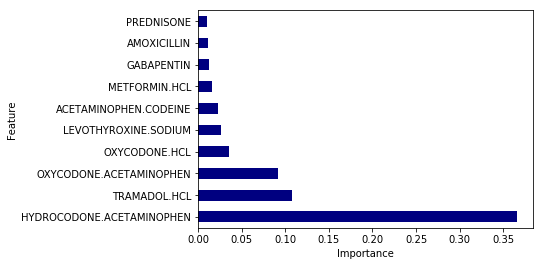

In [50]:
top_feats['Importance'].plot(kind='barh', color='navy')
plt.ylabel('Feature')
plt.xlabel('Importance');
# Same as before, makes sense

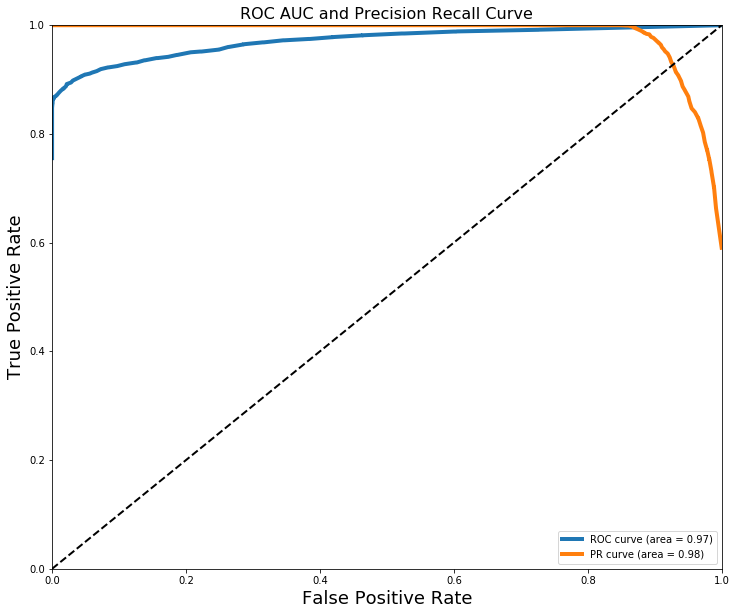

In [56]:
y_hat = gs.predict_proba(X_test)[:,1]

false_pos, true_pos, _ = roc_curve(y_test, y_hat)
ROC_AUC = auc(false_pos, true_pos)
prec, rec, _ = precision_recall_curve(y_test, y_hat)
PR_AUC = auc(rec, prec)

plt.figure(figsize=[12,10])
plt.plot(false_pos, true_pos, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot(rec, prec, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC AUC and Precision Recall Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()